In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages

import dpkt
import numpy as np
import time
import brewer2mpl

import analyze
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

reload(analyze)
host_to_ip, ip_to_host = ReadHosts('experiment_conf/experiment_sc.conf')
interval = 5

In [2]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [3]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [4]:
def compute_everything(prefix='results-profile_k_', capfile='servernode-1-log_agent-tcpdump.cap',
                      verbose=False, krange=[1,2,3,4,5], drange=[2,4,8,10,16,20], shost='servernode-1'):
    throughput = {}
    for k in krange:
        for d in drange:
            filename = prefix + str(k) + '_d_' + str(d) + '/'
            filename += capfile

            if verbose:
                print "Computing throughput for k = %d and d = %d" %(k,d)
            start_time = time.time()
            throughput[(k,d)] = compute_global_throughput(filename, interval, host_to_ip[shost])
            end_time = time.time()
            if verbose:
                print "Time taken is ", end_time - start_time
            
    return throughput

In [30]:
def plot_throughput(in_throughput, in_host_to_ip, krange=[1,2,3,4], drange=[8,16,20], plt_output='throughput-exp1.pdf',
                    host='clientnode-1', backup_host='attacknode-1'):
    host_ip = in_host_to_ip[host]

    # in some of the files, we are using attacknode-1
    attacker_ip = in_host_to_ip[backup_host]

    bmap = brewer2mpl.get_map('PuOr', 'Diverging', 4)
    colors = bmap.mpl_colors


    params = {
       'axes.labelsize': 9,
       'text.fontsize': 10,
       'legend.fontsize': 9,
       'legend.handlelength': 2,
       'xtick.labelsize': 8,
       'ytick.labelsize': 8,
       'text.usetex': False,
       'figure.figsize': [6, 5]
       }
    plt.rcParams.update(params)

    #figure, ax = plt.subplots()
    fig = plt.figure()#figsize=(10,10))
    fig.subplots_adjust(hspace = 0.5, wspace=0.1)
    for k in krange:
        maxbps = 0
        ax = fig.add_subplot(3,2,k)
        #ax.axis('off')
        plotnum = 0
        for d in drange:
            th = in_throughput[(k,d)]

            # if client is not found, use attacker ip
            if host_ip not in th:
                host_th = th[attacker_ip]
            else:
                host_th = th[host_ip]

            host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)
            lbl = 'm=%d' %(d)
            ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', label=lbl, linewidth=2, color=colors[plotnum])
            maxbps = np.maximum(maxbps, np.max(host_bps))
            plotnum += 1

        plt.title('k=%d'%k)
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(-5, maxbps+0.5)
        ax.set_yticks([0,10,20,30])
        ax.set_xticks([0,40,80,120,160])
        
        if k==2 or k==4:
            ax.set_yticklabels([])
            
        if k==3 or k==4:
            ax.set_xlabel('Time (seconds)')
        if k==1 or k==3:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        # offset the spines
        #for spine in ax.spines.values():
        #  spine.set_position(('outward', 5))
        # put the grid behind
        ax.set_axisbelow(True)

    ax = fig.axes[-2]
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.4),borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
    
    plt.savefig('paper-plots/'+plt_output, bbox_inches = 'tight')

## Reading and processing the files

In [6]:
%%capture
throughput_fixed = compute_everything('workdir/profile_fixed_rate/results-profile_k_')

In [7]:
%%capture
throughput_expo = compute_everything('workdir/profile_expo_rate/results-profile_k_')

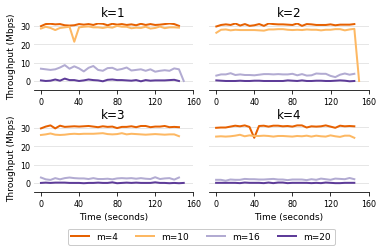

In [31]:
plot_throughput(throughput_expo, host_to_ip, [1,2,3,4], [4,10,16,20])

In [10]:
#lastSubplot.legend(loc = 'lower right', ncol=4)
#frame = legend.get_frame()
#frame.set_facecolor('1.0')
#frame.set_edgecolor('1.0')

# ax = plt.subplot(2,1,2)
# plotnum = 0
# d = 10
# maxbps = 0
# for k in [1,2,3,4,5]:
#     th = throughput[(k,d)]
#     host_bucket, host_bps = get_througput_array (th[host_ip], interval_s=interval)
#     lbl = '(%d,%d)' %(k,d)
#     ax.plot(host_bucket, host_bps, marker=styles[plotnum], label=lbl)
#     maxbps = np.maximum(maxbps, np.max(host_bps))
#     plotnum += 1
    
# ax.grid(True)
# ax.legend(loc='best')
# ax.set_ylim(0, maxbps+2)
# ax.set_xlabel('Time (in seconds)')
# ax.set_ylabel('Throughput (in Mbps)')

## Connection Time

In [11]:
def compute_everything_conn(prefix='results-profile_k_', capfile='clientnode-1-log_agent-tcpdump.cap',
                      verbose=False, krange=[1,2,3,4,5], drange=[2,4,8,10,16,20], shost='servernode-1'):
    connection_time = {}
    for k in krange:
        for d in drange:
            filename = prefix + str(k) + '_d_' + str(d) + '/'
            filename += capfile

            if verbose:
                print "Computing throughput for k = %d and d = %d" %(k,d)
            start_time = time.time()
            connection_time[(k,d)] = parse_file(filename)[0]
            end_time = time.time()
            if verbose:
                print "Time taken is ", end_time - start_time
            
    return connection_time

In [24]:
def plot_conn_time(in_conn, in_host_to_ip, krange=[1,2,3,4], drange=[8,16,20], plt_output='cdf-exp1.pdf',
                    host='clientnode-1', backup_host='attacknode-1',  numbins=50, logx=False):
    host_ip = in_host_to_ip[host]

    # in some of the files, we are using attacknode-1
    attacker_ip = in_host_to_ip[backup_host]

    bmap = brewer2mpl.get_map('OrRd', 'Sequential', 5)
    colors = bmap.mpl_colors
    colors = colors[1:]
    
    params = {
       'axes.labelsize': 9,
       'text.fontsize': 10,
       'legend.fontsize': 9,
       'legend.handlelength': 2,
       'xtick.labelsize': 8,
       'ytick.labelsize': 8,
       'text.usetex': False,
       'figure.figsize': [6, 5]
       }
    plt.rcParams.update(params)

    #figure, ax = plt.subplots()
    fig = plt.figure()#figsize=(10,10))
    fig.subplots_adjust(hspace = 0.65, wspace=0.25)
    for k in krange:
        maxbps = 0
        ax = fig.add_subplot(3,2,k)
        #ax.axis('off')
        plotnum = 0
        for d in drange:
            conn = in_conn[(k,d)]

            # if client is not found, use attacker ip
            if host_ip not in conn:
                host_conn = conn[attacker_ip]
            else:
                host_conn = conn[host_ip]

            host_conn_ro = removeOutliers(host_conn, 5.0)
            values, base = np.histogram(host_conn_ro, bins=numbins, density=True)
            cumulative = np.cumsum(values)*(base[1] - base[0])
            base = base * 1e3
            lbl = 'm=%d' %(d)
            if logx:
                ax.semilogx(base[:-1], cumulative, markerfacecolor='none', 
                    label=lbl, linewidth=2, color=colors[plotnum])#, linestyle=linestyles[plotnum])
            else:
                ax.plot(base[:-1], cumulative, markerfacecolor='none', 
                    label=lbl, linewidth=2, color=colors[plotnum])#, linestyle=linestyles[plotnum])
            maxbps = np.maximum(maxbps, np.max(host_conn))
            plotnum += 1

        plt.title('CDF for k=%d'%k)
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        
        ax.set_ylim(-0.1, 1.05)
        ax.set_yticks([0,0.3,0.6,1])
        
        if k%2==0:
            ax.set_yticklabels([])
            
        if k==3 or k==4:
            ax.set_xlabel('Connection Time ($\mu$s)')
        
        #ax.set_ylabel('Probability of Occurence')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        
        # offset the spines
        #for spine in ax.spines.values():
        #  spine.set_position(('outward', 0))
        
        # put the grid behind
        ax.set_axisbelow(True)

    ax = fig.axes[-2]
    #-0.253
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.4),borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
    
    plt.savefig('paper-plots/'+plt_output, bbox_inches = 'tight')
   

In [13]:
conn_time_global = compute_everything_conn(prefix='workdir/profile_expo_rate/results-profile_k_', 
                                           capfile='clientnode-1-dump_agent-tcpdump.cap',verbose=True)

Computing throughput for k = 1 and d = 2
Time to read pcap file 0.0167481899261
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	5627
Total number of completed connections: 	5627
Total number of retransmissions:       	2
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	1.03069615364
Minimum connection time:               	0.00124287605286
Standard deviation:                    	0.0193724413825
+----------------------------------------------------+
Time taken is  2.70970606804
Computing throughput for k = 1 and d = 4
Time to read pcap file 0.0196309089661
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	5684
Total number of completed connections: 	5684
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete conn

+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	5657
Total number of completed connections: 	5657
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00305700302124
Minimum connection time:               	0.00129103660583
Standard deviation:                    	0.000176843767342
+----------------------------------------------------+
Time taken is  3.22574901581
Computing throughput for k = 3 and d = 8
Time to read pcap file 0.0246160030365
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	5402
Total number of completed connections: 	5402
Total number of retransmissions:       	1
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	1.02313899994
Minimum co

+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	5343
Total number of completed connections: 	5343
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00787806510925
Minimum connection time:               	0.00173687934875
Standard deviation:                    	0.000865549359316
+----------------------------------------------------+
Time taken is  2.60812497139
Computing throughput for k = 5 and d = 10
Time to read pcap file 0.0180461406708
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	4447
Total number of completed connections: 	4447
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.0271852016449
Minimum

Remove 0 outliers from dataset...
Remove 4 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 1 outliers from dataset...
Remove 2 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 2 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 8 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...


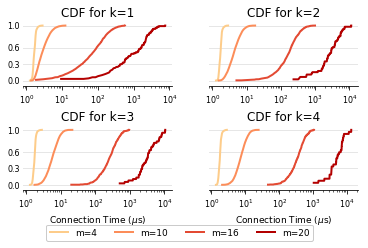

In [25]:
plot_conn_time(conn_time_global, host_to_ip, [1,2,3,4], [4,10,16,20], numbins=500, logx=True)

In [15]:
conn_time_fixed = compute_everything_conn(prefix='workdir/profile_fixed_rate/results-profile_k_', 
                                           capfile='clientnode-1-dump_agent-tcpdump.cap',verbose=True)

Computing throughput for k = 1 and d = 2
Time to read pcap file 0.0210740566254
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	2391
Total number of completed connections: 	2391
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00215697288513
Minimum connection time:               	0.00123906135559
Standard deviation:                    	0.000121228728402
+----------------------------------------------------+
Time taken is  1.44688200951
Computing throughput for k = 1 and d = 4
Time to read pcap file 0.0263609886169
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	2390
Total number of completed connections: 	2390
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete

+----------------------------------------------------+
Statistics for host 10.1.1.3
Total number of attempted connections: 	2391
Total number of completed connections: 	2391
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00240111351013
Minimum connection time:               	0.00133895874023
Standard deviation:                    	0.000125900849473
+----------------------------------------------------+
Time taken is  1.21980810165
Computing throughput for k = 3 and d = 8
Time to read pcap file 0.0125098228455
+----------------------------------------------------+
Statistics for host 10.1.1.3
Total number of attempted connections: 	2387
Total number of completed connections: 	2387
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00584101676941
Minimum

+----------------------------------------------------+
Statistics for host 10.1.1.3
Total number of attempted connections: 	2388
Total number of completed connections: 	2388
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.00792598724365
Minimum connection time:               	0.00170707702637
Standard deviation:                    	0.000855693429815
+----------------------------------------------------+
Time taken is  1.1453268528
Computing throughput for k = 5 and d = 10
Time to read pcap file 0.014445066452
+----------------------------------------------------+
Statistics for host 10.1.1.3
Total number of attempted connections: 	2389
Total number of completed connections: 	2389
Total number of retransmissions:       	0
Total number of dropped connections:   	0
Total number of incomplete connections:	0
Maximum connection time:               	0.20845913887
Minimum con

Remove 0 outliers from dataset...
Remove 2 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 1 outliers from dataset...
Remove 1 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 1 outliers from dataset...
Remove 0 outliers from dataset...
Remove 1 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...
Remove 0 outliers from dataset...


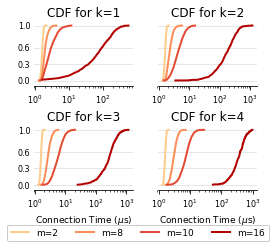

In [16]:
plot_conn_time(conn_time_fixed, host_to_ip, [1,2,3,4], [2,8,10,16], numbins=500, logx=True)